In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# architecture package (your last message)
from architecture_good.deep_binary_classifier import DeepBinaryClassifier
from architecture_good.ripper_node            import make_ripper_node

In [2]:
data_dir          = "data/100_bit_artificial"
dataset_file_path = os.path.join(data_dir, "1a.csv")

df   = pd.read_csv(dataset_file_path)
X    = df.drop(columns="class").to_numpy(bool)
y    = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset shape  : {df.shape}")
print(f"Train /  Test  : {X_train.shape[0]}  /  {X_test.shape[0]}")

Dataset shape  : (10000, 101)
Train /  Test  : 8000  /  2000


In [3]:
num_layers   = 5
num_luts     = 32
lut_bits     = 6

ripper_net = DeepBinaryClassifierMP(
    nodes_per_layer   =[num_luts]*num_layers,
    bits_per_node     =[lut_bits]*(num_layers+1),
    node_factory      =make_ripper_node,
    rng               =42,
    n_jobs            =os.cpu_count(),   # use all cores
    reuse_prev_width  =True,             # mirrors legacy behaviour
)

%time ripper_net.fit(X_train, y_train)

preds_train = ripper_net.predict(X_train)
preds_test  = ripper_net.predict(X_test)

print(f"Accuracy  train: {accuracy_score(y_train, preds_train):.2f}")
print(f"Accuracy  test : {accuracy_score(y_test , preds_test ):.2f}")

CPU times: user 865 ms, sys: 104 ms, total: 969 ms
Wall time: 22.5 s
Accuracy  train: 0.82
Accuracy  test : 0.82


In [4]:
def per_layer_predictions(model, X):
    """Return list of 2-D arrays, one per layer (shape: N × width)."""
    raw, out = X, X
    outs = []
    for idx, layer in enumerate(model.layers):
        pool = out if (model.reuse_prev_width or idx == 0) else np.column_stack((raw, out))
        out  = np.column_stack([n(pool) for n in layer])
        outs.append(out)          # store *after* layer
    return outs

def accuracies_per_layer(model, X, y):
    layer_outs = per_layer_predictions(model, X)
    accs = [ [accuracy_score(y, col) for col in layer.T] for layer in layer_outs ]
    return accs

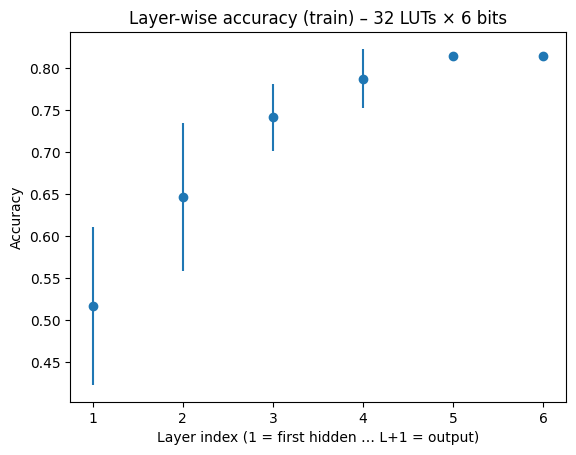

In [5]:
# EXPERIMENT 1 ─ accuracy distribution across the 5 hidden layers
num_layers   = 5
num_luts     = 32
lut_bits     = 6

ripper_net = DeepBinaryClassifierMP(
    nodes_per_layer   =[num_luts]*num_layers,
    bits_per_node     =[lut_bits]*(num_layers+1),
    node_factory      =make_ripper_node,
    rng               =42,
    n_jobs            =os.cpu_count(),
    reuse_prev_width  =True,
)
ripper_net.fit(X_train, y_train)

accs_layers = accuracies_per_layer(ripper_net, X_train, y_train)
mean_accs   = [np.mean(a) for a in accs_layers]
std_accs    = [np.std (a) for a in accs_layers]

plt.errorbar(range(1, num_layers+2), mean_accs, yerr=std_accs, fmt="o")
plt.xticks(range(1, num_layers+2))
plt.title(f"Layer-wise accuracy (train) – {num_luts} LUTs × {lut_bits} bits")
plt.xlabel("Layer index (1 = first hidden … L+1 = output)")
plt.ylabel("Accuracy")
plt.show()

  2 LUTs/layer → train 0.51  |  test 0.48
  4 LUTs/layer → train 0.56  |  test 0.55
  8 LUTs/layer → train 0.70  |  test 0.72
 16 LUTs/layer → train 0.67  |  test 0.66
 32 LUTs/layer → train 0.68  |  test 0.68
 64 LUTs/layer → train 0.88  |  test 0.86


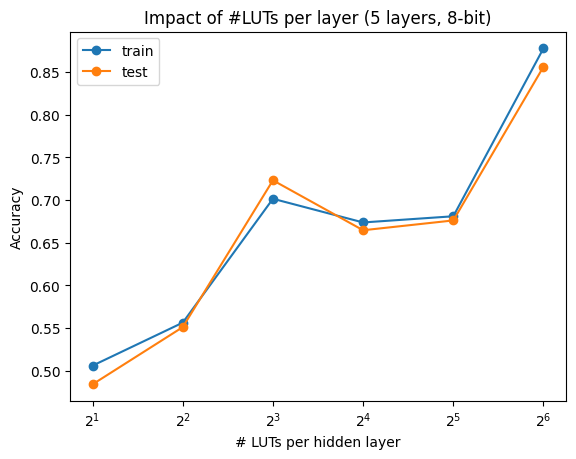

In [6]:
# EXPERIMENT 2 ─ vary *number of LUTs per layer* (fixed 8-bit LUTs)
num_layers       = 5
lut_bits         = 8
luts_per_layer   = [2, 4, 8, 16, 32, 64]

train_acc, test_acc = [], []
for n_luts in luts_per_layer:
    net = DeepBinaryClassifierMP(
        nodes_per_layer   =[n_luts]*num_layers,
        bits_per_node     =[lut_bits]*(num_layers+1),
        node_factory      =make_ripper_node,
        rng               =42,
        n_jobs            =os.cpu_count(),
        reuse_prev_width  =True,
    )
    net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , net.predict(X_test )))

    print(f"{n_luts:>3} LUTs/layer → train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")

plt.plot(luts_per_layer, train_acc, marker="o", label="train")
plt.plot(luts_per_layer, test_acc , marker="o", label="test")
plt.title("Impact of #LUTs per layer (5 layers, 8-bit)")
plt.xlabel("# LUTs per hidden layer")
plt.ylabel("Accuracy")
plt.legend()
plt.xscale("log", base=2)
plt.show()

In [ ]:
# EXPERIMENT 3 ─ vary *input bits per LUT* (fixed 16 LUTs per layer)
num_layers   = 5
luts_per_layer = 16
lut_bits_list  = [2, 4, 8, 16]

train_acc, test_acc = [], []
for lut_bits in lut_bits_list:
    net = DeepBinaryClassifierMP(
        nodes_per_layer   =[luts_per_layer]*num_layers,
        bits_per_node     =[lut_bits]*(num_layers+1),
        node_factory      =make_ripper_node,
        rng               =42,
        n_jobs            =os.cpu_count(),
        reuse_prev_width  =True,
    )
    net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , net.predict(X_test )))

    print(f"{lut_bits:>2}-bit LUT → train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")

plt.plot(lut_bits_list, train_acc, marker="o", label="train")
plt.plot(lut_bits_list, test_acc , marker="o", label="test")
plt.title("Impact of LUT bit-width (5 layers, 16 LUTs/layer)")
plt.xlabel("Bits per LUT")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

 2-bit LUT → train 0.59  |  test 0.58
